In [92]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,mean_squared_log_error

from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor


from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


In [93]:
from pandas.io.parsers import read_csv

df = read_csv("insurance.csv")

In [94]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [132]:
df = df.astype({"sex":"category"})
df = df.astype({"smoker":"category"})
df = df.astype({"region":"category"})

In [134]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


In [135]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

<AxesSubplot:>

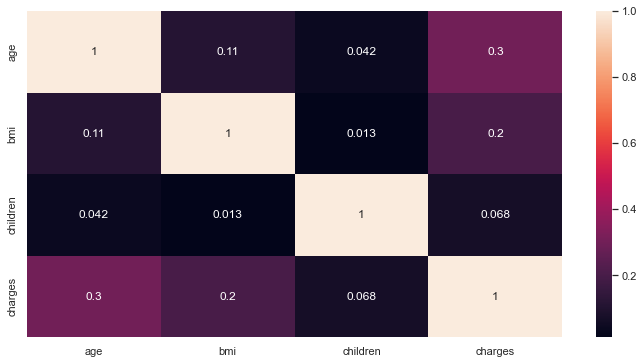

In [137]:
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(),annot=True)

In [155]:
smoker = df[df["smoker"]=="yes"]["smoker"].count()
dontSmoker = df[df["smoker"]=="no"]["smoker"].count()

underWeight = df[df["bmi"]<18.5]["bmi"].count()
healthyWeight = df[(df["bmi"]>=18.5)&(df["bmi"]<24.9)]["bmi"].count()
overWeight = df[(df["bmi"]>=24.9)&(df["bmi"]<29.9)]["bmi"].count()
obeseWeight = df[(df["bmi"]>=29.9)&(df["bmi"]<39.9)]["bmi"].count()
extremlyObeseWeight = df[df["bmi"]>=39.9]["bmi"].count()

baby = df[df["age"]<3]["age"].count()
child = df[(df["age"]>=3)&(df["age"]<17)]["age"].count()
young = df[(df["age"]>=18)&(df["age"]<30)]["age"].count()
adult = df[(df["age"]>=30)&(df["age"]<50)]["age"].count()
old = df[df["age"]>=50]["age"].count()



In [156]:
old


385

In [ ]:
"""
Obezite sınırı kaç kilo?
Obezite Nasıl Ölçülür?
18.5 kg / m²'nin altında olanlar	= Zayıf
18.5-24.9 kg / m² arasında olanlar	= Normal Kilolu
25-29.9 kg / m² arasında olanlar	= Fazla kilolu
30-39.9 kg / m² arasında olanlar	= Obez (şişman)
40 kg / m²'nin üzerinde olanlar	= Morbid obez
"""

<AxesSubplot:xlabel='bmi', ylabel='Count'>

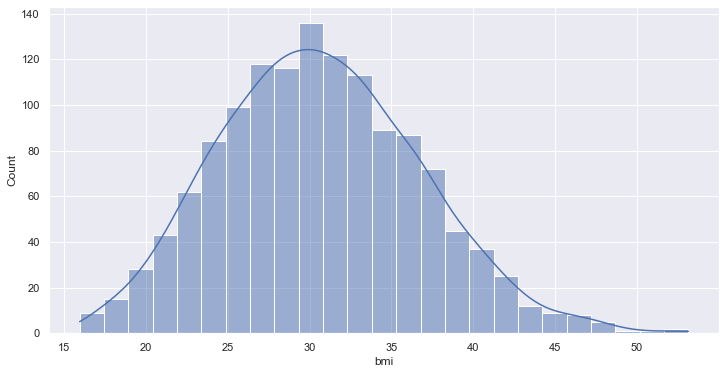

In [101]:
# Bmi(Vücut Kitle İndeksi)’nin dağılımını inceleyiniz.

plt.figure(figsize=(12,6))
sns.set_theme()
sns.histplot(df,x="bmi",kde=True)

<AxesSubplot:xlabel='smoker', ylabel='charges'>

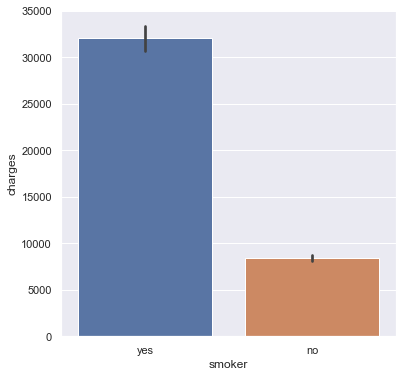

In [102]:
# “smoker” ile “charges” arasındaki ilişkiyi inceleyiniz.
# df[["smoker","charges"]].groupby(["smoker"]).mean()

plt.figure(figsize=(6,6))
sns.barplot(x="smoker",y="charges",data=df)

<AxesSubplot:xlabel='region', ylabel='count'>

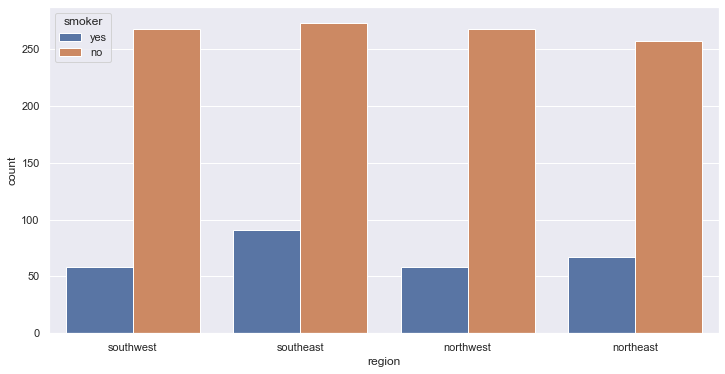

In [103]:
# “smoker” (Sigara tüketen) ile “region”(Bölge) arasındaki ilişkiyi inceleyiniz.

plt.figure(figsize=(12,6))
sns.countplot(x="region",data=df,hue="smoker")



<AxesSubplot:xlabel='sex', ylabel='bmi'>

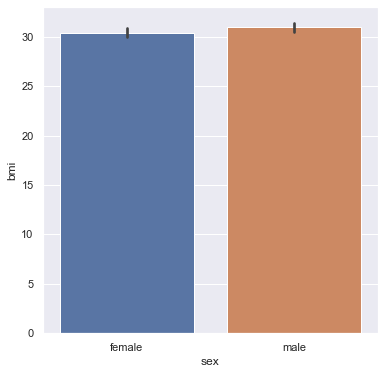

In [104]:
# “bmi” ile “sex”(Cinsiyet) arasındaki ilişkiyi inceleyiniz.

plt.figure(figsize=(6,6))
sns.barplot(x="sex",y="bmi",data=df)


In [105]:
# En çok “children”’a sahip “region”’ı bulunuz.

pi = df[["children"]].groupby(df["region"]).count()

pi

,children
region,
northeast,324
northwest,325
southeast,364
southwest,325


<AxesSubplot:xlabel='bmi', ylabel='age'>

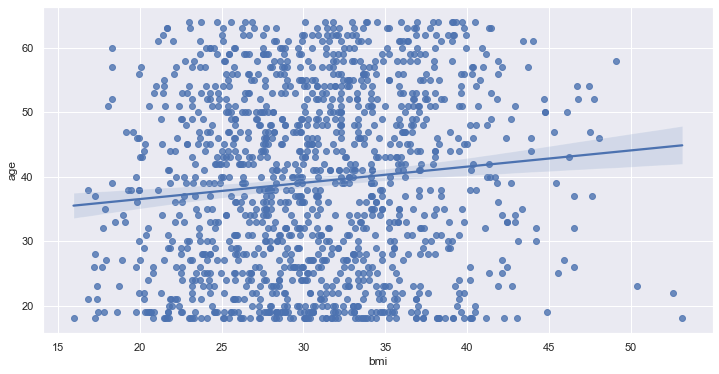

In [106]:
# “Age” ile “bmi” arasındaki ilişkiyi inceleyiniz.
plt.figure(figsize=(12,6))
sns.regplot(x="bmi",y="age",data=df)

<AxesSubplot:xlabel='bmi', ylabel='children'>

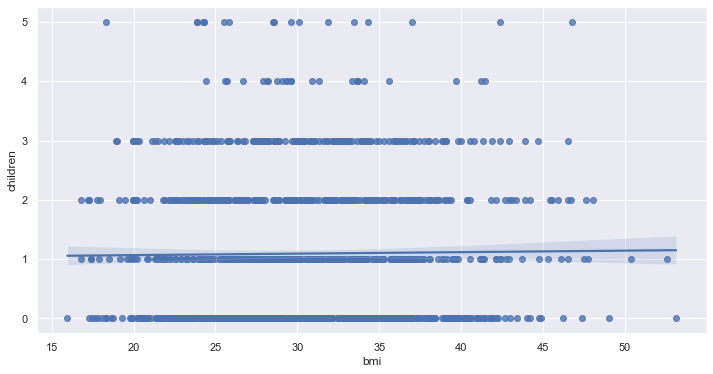

In [107]:
# “bmi” ile “children” arasındaki ilişkiyi inceleyiniz.

plt.figure(figsize=(12,6))
sns.regplot(x="bmi",y="children",data=df)

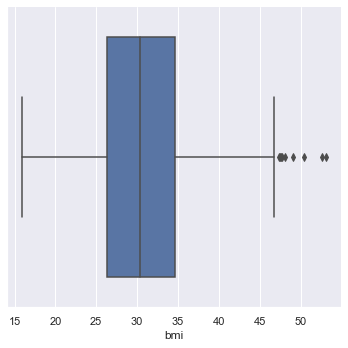

In [108]:
# “bmi” değişkeninde outlier var mıdır? İnceleyiniz.

sns.catplot(x="bmi",data=df,kind="box")

<AxesSubplot:xlabel='bmi', ylabel='charges'>

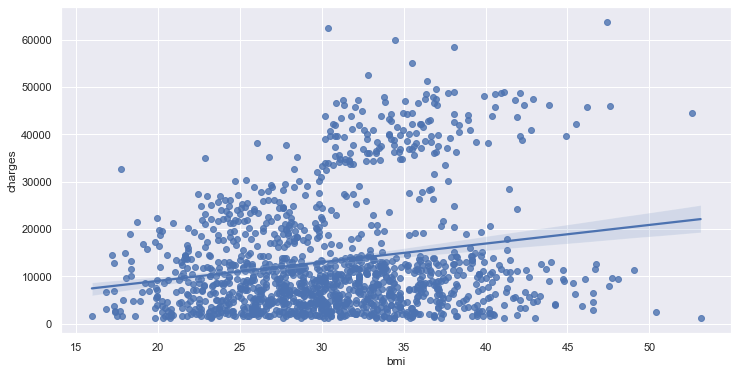

In [109]:
# “bmi” ile “charges” arasındaki ilişkiyi inceleyiniz.

plt.figure(figsize=(12,6))
sns.regplot(x="bmi",y="charges",data=df)

In [110]:
# “region”, “smoker” ve “bmi” arasındaki ilişkiyi bar plot kullanarak inceleyiniz.



In [124]:
num_cols=df._get_numeric_data().columns.tolist()

In [125]:
num_cols

['age', 'bmi', 'children', 'charges']

4. Veri Ön İşleme Yapılması

In [111]:

df.loc[df["sex"]=="male","sex"] = 0
df.loc[df["sex"]=="female","sex"] = 1

df.loc[df["smoker"]=="no","smoker"] = 0
df.loc[df["smoker"]=="yes","smoker"] = 1

df.loc[df["region"]=="northwest","region"] = 0
df.loc[df["region"]=="northeast","region"] = 1
df.loc[df["region"]=="southwest","region"] = 2
df.loc[df["region"]=="southeast","region"] = 3




In [112]:
x = df.drop(["charges"],axis=1)
y = df["charges"]

In [113]:
x

,age,sex,bmi,children,smoker,region
0,19,1,27.900,0,1,2
1,18,0,33.770,1,0,3
2,28,0,33.000,3,0,3
3,33,0,22.705,0,0,0
4,32,0,28.880,0,0,0
...,...,...,...,...,...,...
1333,50,0,30.970,3,0,0
1334,18,1,31.920,0,0,1
1335,18,1,36.850,0,0,3
1336,21,1,25.800,0,0,2


In [114]:
y

0       16884.92400
1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
           ...     
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
1337    29141.36030
Name: charges, Length: 1338, dtype: float64

In [115]:
from sklearn.model_selection import train_test_split

In [116]:
X_train,X_test,Y_train,Y_test= train_test_split(x,y,test_size=0.2,random_state=200)

In [117]:
X_train

,age,sex,bmi,children,smoker,region
225,55,0,33.880,3,0,3
420,64,0,33.880,0,1,3
853,53,1,23.750,2,0,1
289,52,0,26.400,3,0,3
147,51,1,37.730,1,0,3
...,...,...,...,...,...,...
1103,58,0,36.080,0,0,3
844,53,0,30.495,0,0,1
810,46,1,30.800,3,0,2
784,31,1,29.260,1,0,3


In [118]:
X_test

,age,sex,bmi,children,smoker,region
992,50,1,31.600,2,0,2
937,39,1,24.225,5,0,0
688,47,1,24.100,1,0,2
1185,45,0,23.560,2,0,1
1137,26,1,22.230,0,0,0
...,...,...,...,...,...,...
473,47,1,33.345,0,0,1
791,19,0,27.600,0,0,2
1112,48,1,25.850,3,1,3
537,46,1,30.200,2,0,2


In [119]:
Y_train

225     11987.16820
420     46889.26120
853     11729.67950
289     25992.82104
147      9877.60770
           ...     
1103    11363.28320
844     10072.05505
810      9414.92000
784      4350.51440
617     23306.54700
Name: charges, Length: 1070, dtype: float64

In [120]:
Y_test

992     10118.42400
937      8965.79575
688     26236.57997
1185     8603.82340
1137     3176.28770
           ...     
473     20878.78443
791      1252.40700
1112    24180.93350
537      8825.08600
64      14711.74380
Name: charges, Length: 268, dtype: float64

In [121]:
models = []

models.append(("Linear",LinearRegression()))
models.append(("Lasso",Lasso()))
models.append(("Ridge",Ridge()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('SVR', SVR()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('RandomForests', RandomForestRegressor()))
models.append(('GradientBoosting', GradientBoostingRegressor()))

In [122]:
for name,model in models:
    mod = model.fit(X_train,Y_train)
    predictions= mod.predict(X_test)
    rmse = np.sqrt(mean_squared_error(Y_test,predictions))
    print(name,rmse)

Linear 6066.950756527396
Lasso 6066.980209377324
Ridge 6067.882712342837
KNN 12071.714145622278
SVR 13545.05124890791
CART 6484.63135413391
RandomForests 4672.254278310524
GradientBoosting 4320.8106018864755
